In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.models import VGG19_Weights, vgg19
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF
from skimage.metrics import structural_similarity as ssim
from torchvision.utils import save_image
from PIL import Image
from torch.autograd import Variable
import torch.optim as optim
import gc
from tqdm import tqdm
import pickle
import uuid
import math
import neptune

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [41]:
# Function to free up CUDA memory
def free_cuda_memory():
    torch.cuda.empty_cache()
    gc.collect()
free_cuda_memory()

In [4]:
# adding neptune.ai integration for the run

#create a random runid for neptune.ai run
run_id = str(uuid.uuid4())

# initialize a new neptune.ai run
run = neptune.init_run(
    project="ImgResProject/ImageRes",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZTYxYWUwNi0zZWY0LTRkYWMtODA3Ny1lMDU0YTIyZTQ4YzQifQ==",
    tags=["DBPN"],
    name="DBPN-3"
)

# add the runid to neptune.ai id
run["id"] = run_id

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ImgResProject/ImageRes/e/FSRCNN-32


In [16]:
class SuperResolutionDataset(Dataset):
    def __init__(self, low_res_image_dir, high_res_image_dir, csv_file=None, image_data=None, transform=None):
        if image_data is not None:
            self.image_data = image_data
        elif csv_file is not None:
            self.image_data = pd.read_csv(csv_file)
        self.transform = transform
        self.csv_file = csv_file
        self.high_res_image_dir = high_res_image_dir+"/"
        self.low_res_image_dir = low_res_image_dir+"/"

        if len(self.image_data) == 0:
            raise ValueError(f"No image files found in CSV file: {csv_file}")
        
        print(f"Found {len(self.image_data)} image pairs.")

    def __len__(self):
        return len(self.image_data)
    
    def train_val_test_split(self, r1, r2, r3):
        assert r1 + r2 + r3 == 1, "Ratios must sum to 1"
        
        train_data, temp_data = train_test_split(self.image_data, test_size=(1 - r1))
        val_data, test_data = train_test_split(temp_data, test_size=(r3 / (r2 + r3)))
        
        train_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=train_data.reset_index(drop=True),
                                               transform=self.transform)
        
        val_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=val_data.reset_index(drop=True),
                                               transform=self.transform)
        
        test_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=test_data.reset_index(drop=True),
                                               transform=self.transform)
        
        return train_dataset, val_dataset, test_dataset

    def __getitem__(self, index):
        lr_image_path = self.image_data.iloc[index, 0]
        hr_image_path = self.image_data.iloc[index, 1]

        lr_img = Image.open(self.low_res_image_dir+lr_image_path).convert('RGB')
        hr_img = Image.open(self.high_res_image_dir+hr_image_path).convert('RGB')
        
        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)
        return lr_img, hr_img

In [17]:
transform = transforms.Compose([
    # Convert images to tensors
    transforms.ToTensor(),
])
# Initialize the dataset
low_res_dir = 'super_res2/low_res_images'
high_res_dir = 'super_res2/high_res_images'
csv_path = 'super_res2/super_res.csv'
img_dataset = SuperResolutionDataset(low_res_dir, high_res_dir,csv_file=csv_path, transform=transform)

Found 3762 image pairs.


In [19]:
train_dataset, val_dataset, test_dataset = img_dataset.train_val_test_split(0.7, 0.15, 0.15)

Found 2633 image pairs.
Found 564 image pairs.
Found 565 image pairs.


In [20]:
# Print number of images in each split
print(f"Number of images in train set: {len(train_dataset)}")
print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")

Number of images in train set: 2633
Number of images in validation set: 564
Number of images in test set: 565


In [21]:
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)

In [22]:
# Function to show lowres and high res images side by side
def show_tensorpair(tensor_pair):
    lr_img = tensor_pair[0].cpu().numpy()
    hr_img = tensor_pair[1].cpu().numpy()
    lr_img = lr_img.transpose(1,2,0)
    hr_img = hr_img.transpose(1,2,0)

    lr_img = np.clip(lr_img, 0, 1)
    hr_img = np.clip(hr_img, 0, 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(lr_img, cmap='gray')
    axs[0].set_title('Low-res Image')
    axs[0].axis('off')
    axs[1].imshow(hr_img, cmap='gray')
    axs[1].set_title('High-res Image')
    axs[1].axis('off')
    
    plt.show()

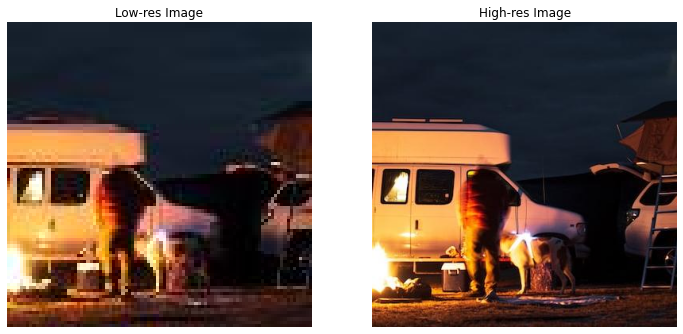

In [23]:
show_tensorpair(train_dataset[18])

In [3]:
# Function to initialize model weights with kaiming weights
def initialize_kaiming_weights(module):
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.kaiming_normal_(module.weight)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

In [4]:
# Defining the convolution block containing single convolution layer
class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=3, stride=1, padding=1, bias=True, activation='prelu', norm=None):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=bias)

        self.norm = norm
        # Initialize batchnormalization layer depending on the input parameter
        if self.norm =='batch':
            self.bn = torch.nn.BatchNorm2d(output_size)

        self.activation = activation
        # Assign activation function layer depending on the input parameter
        if self.activation == 'prelu':
            self.act = torch.nn.PReLU()
        elif self.activation == 'lrelu':
            self.act = torch.nn.LeakyReLU(0.2, True)

    def forward(self, x):
        if self.norm is not None:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)

        if self.activation is not None:
            return self.act(out)
        else:
            return out

In [5]:
# Defining the deconvolution block containing single deconvolution layer
class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, bias=True, activation='prelu', norm=None):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding, bias=bias)

        self.norm = norm
        # Initialize batchnormalization layer depending on the input parameter
        if self.norm == 'batch':
            self.bn = torch.nn.BatchNorm2d(output_size)

        self.activation = activation
        # Assign activation function layer depending on the input parameter
        if self.activation == 'prelu':
            self.act = torch.nn.PReLU()
            
    def forward(self, x):
        if self.norm is not None:
            out = self.bn(self.deconv(x))
        else:
            out = self.deconv(x)

        if self.activation is not None:
            return self.act(out)
        else:
            return out

In [6]:
# Implementing the Up-Projection unit of the DBPN network
class UpBlock(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=8, stride=4, padding=2, bias=True, activation='prelu', norm=None):
        super(UpBlock, self).__init__()
        self.up_conv1 = DeconvBlock(num_filter, num_filter, kernel_size, stride, padding, activation, norm=None)
        self.up_conv2 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation, norm=None)
        self.up_conv3 = DeconvBlock(num_filter, num_filter, kernel_size, stride, padding, activation, norm=None)        

    def forward(self, x):
        h0 = self.up_conv1(x)
        l0 = self.up_conv2(h0)
        h1 = self.up_conv3(l0 - x)
        return h1 + h0

In [7]:
# Implementing the Dense Up-Projection unit of the DBPN network
class DenseUpBlock(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=8, stride=4, padding=2, num_stages=1, bias=True, activation='prelu', norm=None):
        super(DenseUpBlock, self).__init__()
        self.conv = ConvBlock(num_filter*num_stages, num_filter, 1, 1, 0, activation, norm=None)
        self.up_conv1 = DeconvBlock(num_filter, num_filter, kernel_size, stride, padding, activation, norm=None)
        self.up_conv2 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation, norm=None)
        self.up_conv3 = DeconvBlock(num_filter, num_filter, kernel_size, stride, padding, activation, norm=None)        

    def forward(self, x):
        x = self.conv(x)
        h0 = self.up_conv1(x)
        l0 = self.up_conv2(h0)
        h1 = self.up_conv3(l0 - x)
        return h1 + h0

In [8]:
# Implementing the Down-Projection unit of the DBPN network
class DownBlock(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=8, stride=4, padding=2, bias=True, activation='prelu', norm=None):
        super(DownBlock, self).__init__()
        self.down_conv1 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation, norm=None)
        self.down_conv2 = DeconvBlock(num_filter, num_filter, kernel_size, stride, padding, activation, norm=None)
        self.down_conv3 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation, norm=None)

    def forward(self, x):
        l0 = self.down_conv1(x)
        h0 = self.down_conv2(l0)
        l1 = self.down_conv3(h0 - x)
        return l1 + l0

In [9]:
# Implementing the Dense Down-Projection unit of the DBPN network
class DenseDownBlock(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=8, stride=4, padding=2, num_stages=1, bias=True, activation='prelu', norm=None):
        super(DenseDownBlock, self).__init__()
        self.conv = ConvBlock(num_filter*num_stages, num_filter, 1, 1, 0, activation, norm=None)
        self.down_conv1 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation, norm=None)
        self.down_conv2 = DeconvBlock(num_filter, num_filter, kernel_size, stride, padding, activation, norm=None)
        self.down_conv3 = ConvBlock(num_filter, num_filter, kernel_size, stride, padding, activation, norm=None)

    def forward(self, x):
        x = self.conv(x)
        l0 = self.down_conv1(x)
        h0 = self.down_conv2(l0)
        l1 = self.down_conv3(h0 - x)
        return l1 + l0


In [10]:
# Implementing the generator network of DBPN
class DBPN(nn.Module):
    def __init__(self, num_channels, base_filter, feat, num_stages, scale_factor):
        super(DBPN, self).__init__()
          
        kernel = 8
        stride = 4
        padding = 2
        
        # Implementing the initial convolution layers
        # 3x3 conv layer
        self.feat0 = ConvBlock(num_channels, feat, 3, 1, 1, activation='prelu', norm=None)
        # 1x1 conv layer
        self.feat1 = ConvBlock(feat, base_filter, 1, 1, 0, activation='prelu', norm=None)
        # Implementing the back-projection layers by alternating between up-projection and down-projection layers
        self.up1 = UpBlock(base_filter, kernel, stride, padding)
        self.down1 = DownBlock(base_filter, kernel, stride, padding)
        self.up2 = UpBlock(base_filter, kernel, stride, padding)
        self.down2 = DenseDownBlock(base_filter, kernel, stride, padding, 2)
        self.up3 = DenseUpBlock(base_filter, kernel, stride, padding, 2)
        self.down3 = DenseDownBlock(base_filter, kernel, stride, padding, 3)
        self.up4 = DenseUpBlock(base_filter, kernel, stride, padding, 3)
        self.down4 = DenseDownBlock(base_filter, kernel, stride, padding, 4)
        self.up5 = DenseUpBlock(base_filter, kernel, stride, padding, 4)
        self.down5 = DenseDownBlock(base_filter, kernel, stride, padding, 5)
        self.up6 = DenseUpBlock(base_filter, kernel, stride, padding, 5)
        self.down6 = DenseDownBlock(base_filter, kernel, stride, padding, 6)
        self.up7 = DenseUpBlock(base_filter, kernel, stride, padding, 6)
        # Reconstruction the image output - 3x3 conv
        self.output_conv = ConvBlock(num_stages*base_filter, num_channels, 3, 1, 1, activation=None, norm=None)
        
        # Initialize model with kaiming weights
        self.apply(initialize_kaiming_weights)
            
    def forward(self, x):
        x = self.feat0(x)
        x = self.feat1(x)

        h1 = self.up1(x)
        l1 = self.down1(h1)

        h2 = self.up2(l1)
        l2 = self.down2(torch.cat((h2, h1), 1))

        h3 = self.up3(torch.cat((l2, l1), 1))
        l3 = self.down3(torch.cat((h3, h2, h1), 1))

        h4 = self.up4(torch.cat((l3, l2, l1), 1))
        l4 = self.down4(torch.cat((h4, h3, h2, h1), 1))

        h5 = self.up5(torch.cat((l4, l3, l2, l1), 1))
        l5 = self.down5(torch.cat((h5, h4, h3, h2, h1), 1))

        h6 = self.up6(torch.cat((l5, l4, l3, l2, l1), 1))
        l6 = self.down6(torch.cat((h6, h5, h4, h3, h2, h1), 1))

        h7 = self.up7(torch.cat((l6, l5, l4, l3, l2, l1), 1))
        x = self.output_conv(torch.cat((h7, h6, h5, h4, h3, h2, h1), 1))

        return x

In [11]:
# Implementing DenseBlock unit for discriminator contianing of linear layer
class DenseBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, bias=True, activation='relu'):
        super(DenseBlock, self).__init__()
        self.fc = torch.nn.Linear(input_size, output_size, bias=bias)

        self.activation = activation
        # Assign activation function layer depending on the input parameter
        if self.activation == 'lrelu':
            self.act = torch.nn.LeakyReLU(0.2, True)
        elif self.activation == 'sigmoid':
            self.act = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.fc(x)

        if self.activation is not None:
            return self.act(out)
        else:
            return out

In [12]:
# Implementing the discriminator network of DBPN
class Discriminator(nn.Module):
    def __init__(self, num_channels, base_filter, image_size):
        super(Discriminator, self).__init__()
        self.image_size = image_size

        self.input_conv = ConvBlock(num_channels, base_filter, 3, 1, 1, activation='lrelu', norm=None)

        self.conv_blocks = nn.Sequential(
            ConvBlock(base_filter, base_filter, 3, 2, 1, activation='lrelu', norm ='batch'),
            ConvBlock(base_filter, base_filter * 2, 3, 1, 1, activation='lrelu', norm ='batch'),
            ConvBlock(base_filter * 2, base_filter * 2, 3, 2, 1, activation='lrelu', norm ='batch'),
            ConvBlock(base_filter * 2, base_filter * 4, 3, 1, 1, activation='lrelu', norm ='batch'),
            ConvBlock(base_filter * 4, base_filter * 4, 3, 2, 1, activation='lrelu', norm ='batch'),
            ConvBlock(base_filter * 4, base_filter * 8, 3, 1, 1, activation='lrelu', norm ='batch'),
            ConvBlock(base_filter * 8, base_filter * 8, 3, 2, 1, activation='lrelu', norm ='batch'),
        )

        self.dense_layers = nn.Sequential(
            DenseBlock(base_filter * 8 * image_size // 16 * image_size // 16, base_filter * 16, activation='lrelu'),
            DenseBlock(base_filter * 16, 1, activation='sigmoid')
        )
        
        # Initialize model with kaiming weights
        self.apply(initialize_kaiming_weights)

    def forward(self, x):
        out = self.input_conv(x)
        out = self.conv_blocks(out)
        out = out.flatten(start_dim=1)
        out = self.dense_layers(out)
        return out

In [34]:
# Function to extract features from pre-trained VGG19 model
class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=35):
        super(VGGFeatureExtractor, self).__init__()
        vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:feature_layer]).to(device)
    
    def forward(self, x):
        return self.feature_extractor(x)

In [35]:
# Function to calculate peak signal-to-noise ratio
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * math.log10(max_pixel / math.sqrt(mse.item()))

In [82]:
# Function to calculate structural similarity index
def calculate_ssim(img1, img2):

    # initialize required value to store ssim avlues for each image
    ssim_values = []
    batch_size= img1.shape[0]
    

    # iterate over each image in the batch
    for i in range(batch_size):

        # average SSIM values across channels
        opimg = np.transpose(img1[i].cpu().numpy(), (1, 2, 0))
        ogimg = np.transpose(img2[i].cpu().numpy(), (1, 2, 0))

        ssim_val = ssim(opimg, ogimg, channel_axis=-1, data_range=ogimg.max() - ogimg.min())
        # take mean of all channels as ssim value for the image
        ssim_values.append(np.mean(ssim_val))

    # if there are any nan values then make it 0.0
    ssim_values = [0.0 if np.isnan(x) else x for x in ssim_values]

    if np.isnan(np.mean(ssim_values)):
        print(ssim_values)

    # return avrage of all images in the batch and return it as ssim value of all images in the batch
    return np.mean(ssim_values)

In [37]:
# function to evaluate the model on validation set
def validate_model(generator, val_loader, device):
    generator.eval()
    psnr = 0.0
    ssim_val = 0.0
    with torch.no_grad():
        for i, (lr_imgs, hr_imgs) in enumerate(tqdm(val_loader, desc="Validating...")):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            gen_hr = generator(lr_imgs)
            
            # Accumulate psnr for each batch
            psnr += calculate_psnr(gen_hr, hr_imgs)
            # Accumulate ssim for each batch
            ssim_val += calculate_ssim(gen_hr, hr_imgs)
            

            del lr_imgs, hr_imgs, gen_hr
            free_cuda_memory()
    # Calculate average psnr for the entire validation set
    psnr = psnr / len(val_loader)
    # Calculate average ssim for the entire validation set
    ssim_val = ssim_val / len(val_loader)
    
    return psnr, ssim_val

In [38]:
# Directory to save model weights
save_dir = 'DBPN_neptune_model_weights'
os.makedirs(save_dir, exist_ok=True)

# Function to save model weights
def save_weights(epoch, generator, discriminator, save_dir, log = False):
    if log == True:
        gen_path = os.path.join(save_dir, f'generator_epoch.pth')
        disc_path = os.path.join(save_dir, f'discriminator_epoch.pth')
    else:
        gen_path = os.path.join(save_dir, f'generator_epoch_{epoch}.pth')
        disc_path = os.path.join(save_dir, f'discriminator_epoch_{epoch}.pth')
    
    torch.save(generator.state_dict(), gen_path)
    
    torch.save(discriminator.state_dict(), disc_path)

In [13]:
# Initialize generator, discriminator and vgg features
dbpn = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
discriminator = Discriminator(num_channels=3, base_filter=64, image_size=384).to(device)

In [14]:
save_dir = 'DBPN_neptune_model_weights'

gen_path = os.path.join(save_dir, f'generator_epoch.pth')
disc_path = os.path.join(save_dir, f'discriminator_epoch.pth')

In [15]:
# Loading the saved weights if necessary
# dbpn.load_state_dict(torch.load(gen_path))
# discriminator.load_state_dict(torch.load(disc_path))

<All keys matched successfully>

In [45]:
learning_rate = 0.0001
epsi = 1e-8

G_optimizer = optim.Adam(dbpn.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=epsi)
D_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=epsi)

In [46]:
# Logging the parameters for neptuneai
params = {"learning_rate": learning_rate, "optimizer": "Adam", "Cropped image": True, "Crop specs": "Center, 96-96", "Epsilon":epsi}
run["parameters"] = params

In [47]:
feature_extractor = VGGFeatureExtractor().eval()
MSE_loss = nn.MSELoss().to(device)
BCE_loss = nn.BCELoss().to(device)

In [59]:
d_losses = []
g_losses = []
content_loss = []
psnr_values = []
ssim_values = []

In [45]:
# Load the training metrics from previous epochs for graph visualization, if necessary
# with open('dbpn_neptune_losses.pkl', 'rb') as f:
#     losses = pickle.load(f)
#     g_losses = losses['g_losses']
#     d_losses = losses['d_losses']
#     content_loss = losses['content_loss']
#     psnr_values = losses['psnr_values']
#     ssim_values = losses['ssim_values']

In [69]:
num_epochs = 17

In [73]:
old_epoch = len(g_losses)
print(old_epoch)

53


In [74]:
old_epoch = len(g_losses)

for epoch in range(num_epochs):
    epoch_loss_G = 0.0
    epoch_loss_D = 0.0
    epoch_content_loss = 0.0
    dbpn.train()
    discriminator.train()
    
    for i, (lr_imgs, hr_imgs) in enumerate(tqdm(train_loader, desc=f"Epoch {old_epoch+epoch+1}/{old_epoch+num_epochs}")):
        # Create tensors of ones and zeroes of length equal to batch size
        valid = torch.ones(hr_imgs.size(0), 1).to(device)
        fake = torch.zeros(hr_imgs.size(0), 1).to(device)

        # Push the input images and target images to CUDA
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)
        
        D_optimizer.zero_grad()
        
        # Train discriminator with target images
        D_real_decision = discriminator(hr_imgs)
        D_real_loss = BCE_loss(D_real_decision, valid)
        
        # Generate a high-resolution image from low-resolution input
        recon_image = dbpn(lr_imgs)
        D_fake_decision = discriminator(recon_image)
        D_fake_loss = BCE_loss(D_fake_decision, fake)
        # Calcualte total discriminator loss by taking sum of real loss and fake loss
        loss_D = D_real_loss + D_fake_loss
        
        # Back propagation
        loss_D.backward()
        D_optimizer.step()
        
        G_optimizer.zero_grad()
        
        # Generate a high-resolution image from low-resolution input
        recon_image = dbpn(lr_imgs)
        D_fake_decision = discriminator(recon_image)
        # Generate a high-resolution image from low-resolution input
        loss_GAN = BCE_loss(D_fake_decision, valid)
        
        # Calculate pixel loss by comparing the generated image with high res image
        mse_loss = MSE_loss(recon_image, hr_imgs)
        
        x_VGG = hr_imgs.to(device)
        recon_VGG = recon_image.detach().to(device)
        real_feature = feature_extractor(x_VGG)
        fake_feature = feature_extractor(recon_VGG)
        
        vgg_loss = 0.01 * sum(MSE_loss(fake_feature[i], real_feature[i].detach()) for i in range(len(real_feature)))
        epoch_content_loss+=vgg_loss
        
        # Calculate the total loss. Note that we prioritize pixel loss
        loss_G = mse_loss + 0.001 * loss_GAN + 0.006 * vgg_loss
        
        loss_G.backward()
        G_optimizer.step()
        
        # Accumulate the losses accross all batches
        epoch_loss_G += loss_G.item()
        epoch_loss_D += loss_D.item()
    
    # Take the average losses for the epoch
    avg_content_loss = epoch_content_loss / len(train_loader)
    avg_loss_G = epoch_loss_G / len(train_loader)
    avg_loss_D = epoch_loss_D / len(train_loader)
    
    # Append to lists
    d_losses.append(avg_loss_D)
    g_losses.append(avg_loss_G)
    content_loss.append(avg_content_loss.cpu().item())
    
    save_weights(old_epoch+num_epochs,dbpn, discriminator, save_dir, log=True)
    
    print(f"Epoch {old_epoch+epoch+1} completed: Disc loss: {avg_loss_D}, Gen loss: {avg_loss_G}, Content loss: {avg_content_loss}")
    
    
    epoch_psnr, epoch_ssim = validate_model(dbpn, val_loader, device)
    psnr_values.append(epoch_psnr)
    ssim_values.append(epoch_ssim)
    
    # Log the metrics to neptune.ai
    run["train/disc_loss"].append(avg_loss_D)
    run["train/gen_loss"].append(avg_loss_G)
    run["train/content_loss"].append(avg_content_loss)
    run["val/psnr"].append(epoch_psnr)
    run["val/ssim"].append(epoch_ssim)
    
    print(f"Validation Epoch {old_epoch+epoch+1} completed: PSNR: {epoch_psnr}, SSIM: {epoch_ssim}")
    
    # Storing the training metrics into pkl file for later usage
    with open('dbpn_neptune_losses.pkl', 'wb') as file:
        pickle.dump({'g_losses': g_losses,
                     'd_losses': d_losses,
                     'content_loss': content_loss,
                     'psnr_values':psnr_values,
                     'ssim_values':ssim_values}, file)
    free_cuda_memory()
    
save_weights(old_epoch+num_epochs,dbpn, discriminator, save_dir)

Epoch 54/70: 100%|██████████| 878/878 [11:42<00:00,  1.25it/s]


Epoch 54 completed: Disc loss: 100.0, Gen loss: 0.002913512610992128, Content loss: 0.03252396360039711


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.18it/s]


Validation Epoch 54 completed: PSNR: 26.203251961583515, SSIM: 0.7456604469012706


Epoch 55/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 55 completed: Disc loss: 100.0, Gen loss: 0.002841956349824829, Content loss: 0.03211989253759384


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.21it/s]


Validation Epoch 55 completed: PSNR: 26.34215421824812, SSIM: 0.7492424385978821


Epoch 56/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 56 completed: Disc loss: 100.0, Gen loss: 0.002821970961132492, Content loss: 0.031959548592567444


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.24it/s]


Validation Epoch 56 completed: PSNR: 26.12763918466226, SSIM: 0.7451405848594422


Epoch 57/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 57 completed: Disc loss: 100.0, Gen loss: 0.0027631796820018683, Content loss: 0.031580712646245956


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.22it/s]


Validation Epoch 57 completed: PSNR: 26.220779855848633, SSIM: 0.7445680591020178


Epoch 58/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 58 completed: Disc loss: 100.0, Gen loss: 0.0027124078241988364, Content loss: 0.0312928706407547


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.21it/s]


Validation Epoch 58 completed: PSNR: 26.493578511576654, SSIM: 0.7535694761479155


Epoch 59/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 59 completed: Disc loss: 100.0, Gen loss: 0.0026883836102723365, Content loss: 0.031136583536863327


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.20it/s]


Validation Epoch 59 completed: PSNR: 26.52551193373205, SSIM: 0.754383996763128


Epoch 60/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 60 completed: Disc loss: 100.0, Gen loss: 0.002625761291346033, Content loss: 0.030739333480596542


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.21it/s]


Validation Epoch 60 completed: PSNR: 26.510548096071034, SSIM: 0.7527234280045997


Epoch 61/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 61 completed: Disc loss: 100.0, Gen loss: 0.0026025724707359334, Content loss: 0.03054369054734707


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.21it/s]


Validation Epoch 61 completed: PSNR: 26.539279065535673, SSIM: 0.7524323403201205


Epoch 62/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 62 completed: Disc loss: 100.0, Gen loss: 0.0025569591576425498, Content loss: 0.03032517433166504


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.19it/s]


Validation Epoch 62 completed: PSNR: 26.603337682423707, SSIM: 0.7554885466048058


Epoch 63/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 63 completed: Disc loss: 100.0, Gen loss: 0.002531741028665517, Content loss: 0.030120329931378365


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.23it/s]


Validation Epoch 63 completed: PSNR: 26.609164874190192, SSIM: 0.7559369431531175


Epoch 64/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 64 completed: Disc loss: 100.0, Gen loss: 0.0024845818585735014, Content loss: 0.029840338975191116


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.23it/s]


Validation Epoch 64 completed: PSNR: 26.71378298481344, SSIM: 0.7584188650263116


Epoch 65/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 65 completed: Disc loss: 100.0, Gen loss: 0.0024613047289034377, Content loss: 0.02966388687491417


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.19it/s]


Validation Epoch 65 completed: PSNR: 26.713416333230587, SSIM: 0.7568464990943036


Epoch 66/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 66 completed: Disc loss: 100.0, Gen loss: 0.0024121782190793836, Content loss: 0.029382579028606415


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.23it/s]


Validation Epoch 66 completed: PSNR: 26.585645935683377, SSIM: 0.7557076477306954


Epoch 67/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 67 completed: Disc loss: 100.0, Gen loss: 0.00240725557787901, Content loss: 0.029345279559493065


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.23it/s]


Validation Epoch 67 completed: PSNR: 26.785719034978875, SSIM: 0.7623692032821635


Epoch 68/70: 100%|██████████| 878/878 [11:42<00:00,  1.25it/s]


Epoch 68 completed: Disc loss: 100.0, Gen loss: 0.0023744601029998163, Content loss: 0.029104938730597496


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.23it/s]


Validation Epoch 68 completed: PSNR: 26.8250489796245, SSIM: 0.7610259287534876


Epoch 69/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 69 completed: Disc loss: 100.0, Gen loss: 0.0023400634343898694, Content loss: 0.028878536075353622


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.22it/s]


Validation Epoch 69 completed: PSNR: 26.725955589166876, SSIM: 0.7619849088344168


Epoch 70/70: 100%|██████████| 878/878 [11:41<00:00,  1.25it/s]


Epoch 70 completed: Disc loss: 100.0, Gen loss: 0.0023190495989005378, Content loss: 0.028755847364664078


Validating...: 100%|██████████| 188/188 [00:44<00:00,  4.23it/s]


Validation Epoch 70 completed: PSNR: 26.874796408858387, SSIM: 0.7632015518685604


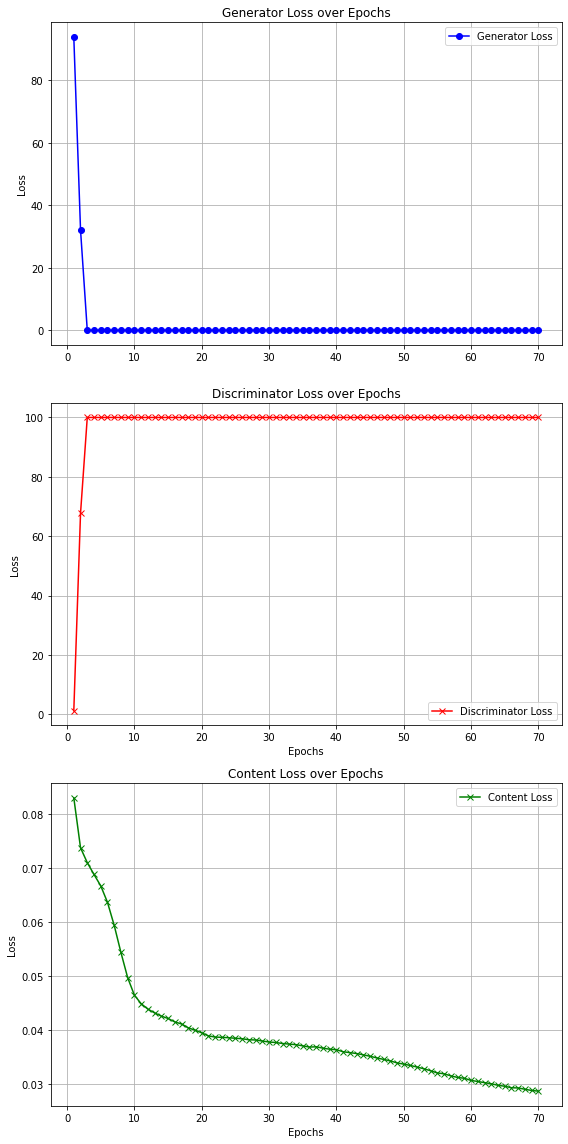

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 16), sharex=False)
total_epochs = len(g_losses)
# Plotting generator Loss vs epoch
ax1.plot(range(1, total_epochs + 1), g_losses, label='Generator Loss', marker='o', color='b')
ax1.set_title('Generator Loss over Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# Plotting discriminator Loss vs epoch
ax2.plot(range(1, total_epochs + 1), d_losses, label='Discriminator Loss', marker='x', color='r')
ax2.set_title('Discriminator Loss over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.legend()

# Plotting content Loss vs epoch
ax3.plot(range(1, total_epochs + 1), content_loss, label='Content Loss', marker='x', color='g')
ax3.set_title('Content Loss over Epochs')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

In [77]:
# Function to evaluate the model on test set
def test_model(generator, test_loader, img_cnt=5):
    generator.eval()
    psnr = 0.0
    ssim_val = 0.0
    count = 0
    with torch.no_grad():
        for i, (lr_imgs, hr_imgs) in enumerate(tqdm(test_loader, desc="Testing")):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            gen_hr = generator(lr_imgs)
            # Accumulate the psnr and ssim values over each batch
            psnr += calculate_psnr(gen_hr, hr_imgs)
            ssim_val += calculate_ssim(gen_hr, hr_imgs)
            if count < img_cnt:
                count += 1
                display_compare_images(lr_imgs, hr_imgs, gen_hr)
            del lr_imgs, hr_imgs, gen_hr
            free_cuda_memory()
    # Calculate the psnr and ssim values for each epoch
    psnr = psnr / len(test_loader)
    ssim_val = ssim_val/len(test_loader)
    print(f'PSNR value for testing dataset is : {psnr}')
    print(f'SSIM value for testing dataset is : {ssim_val}')

In [78]:
def display_compare_images(lr, hr, op):
    itr = lr.size(0)
    fig, ax = plt.subplots(3, itr, figsize=(20, 12))
    if itr == 1:
        ax[0].imshow(lr[0].permute(1, 2, 0).cpu().numpy())
        ax[0].set_title("Low res image")
        ax[0].axis('off')
        ax[1].imshow(hr[0].permute(1, 2, 0).cpu().numpy())
        ax[1].set_title("High res image")
        ax[1].axis('off')
        ax[2].imshow(op[0].permute(1, 2, 0).cpu().numpy())
        ax[2].set_title("Super resolved image")
        ax[2].axis('off')
    else:
        for i in range(itr):
            lrimg = lr[i].permute(1, 2, 0).cpu().numpy()
            hrimg = hr[i].permute(1, 2, 0).cpu().numpy()
            opimg = op[i].permute(1, 2, 0).cpu().numpy()
            ax[0, i].imshow(lrimg)
            ax[0, i].set_title("Low res image")
            ax[0, i].axis('off')
            ax[1, i].imshow(hrimg)
            ax[1, i].set_title("High res image")
            ax[1, i].axis('off')
            ax[2, i].imshow(opimg)
            ax[2, i].set_title("Super resolved image")
            ax[2, i].axis('off')
    plt.tight_layout()
    plt.show()

Testing:   0%|          | 0/189 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


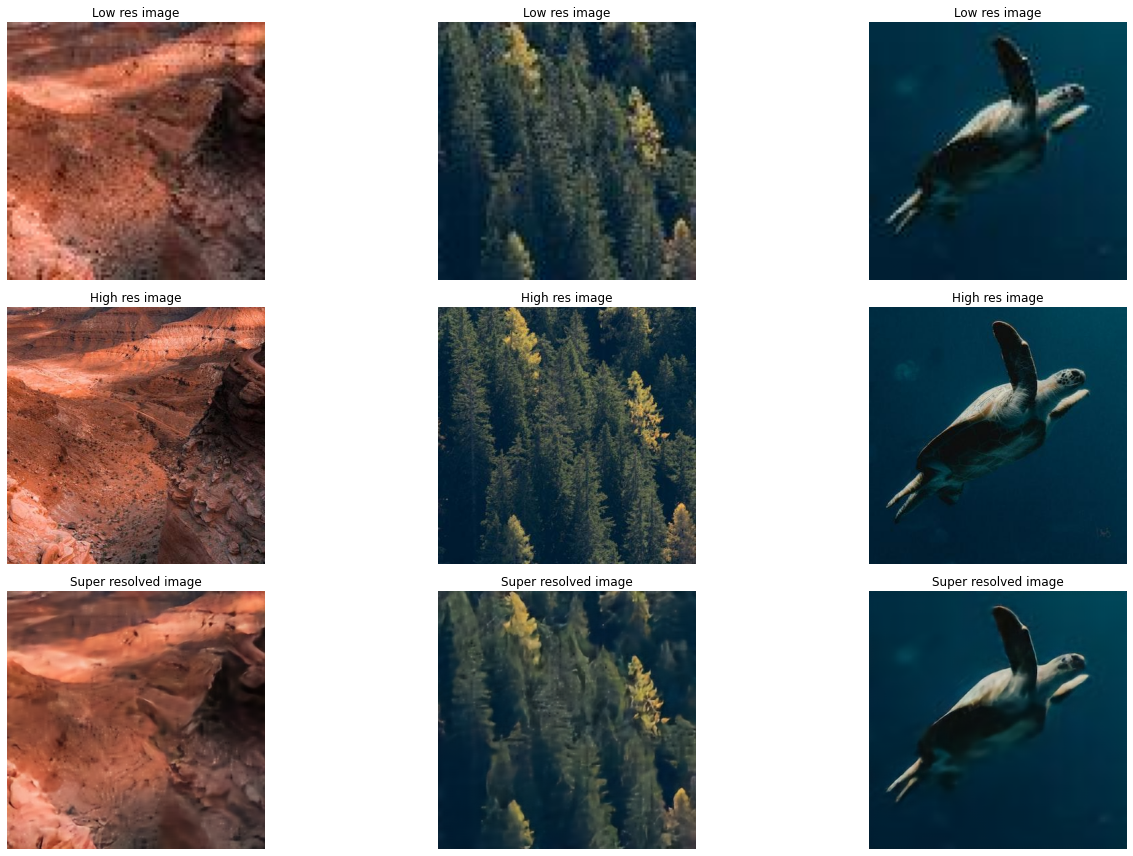

Testing:   1%|          | 1/189 [00:00<02:35,  1.21it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


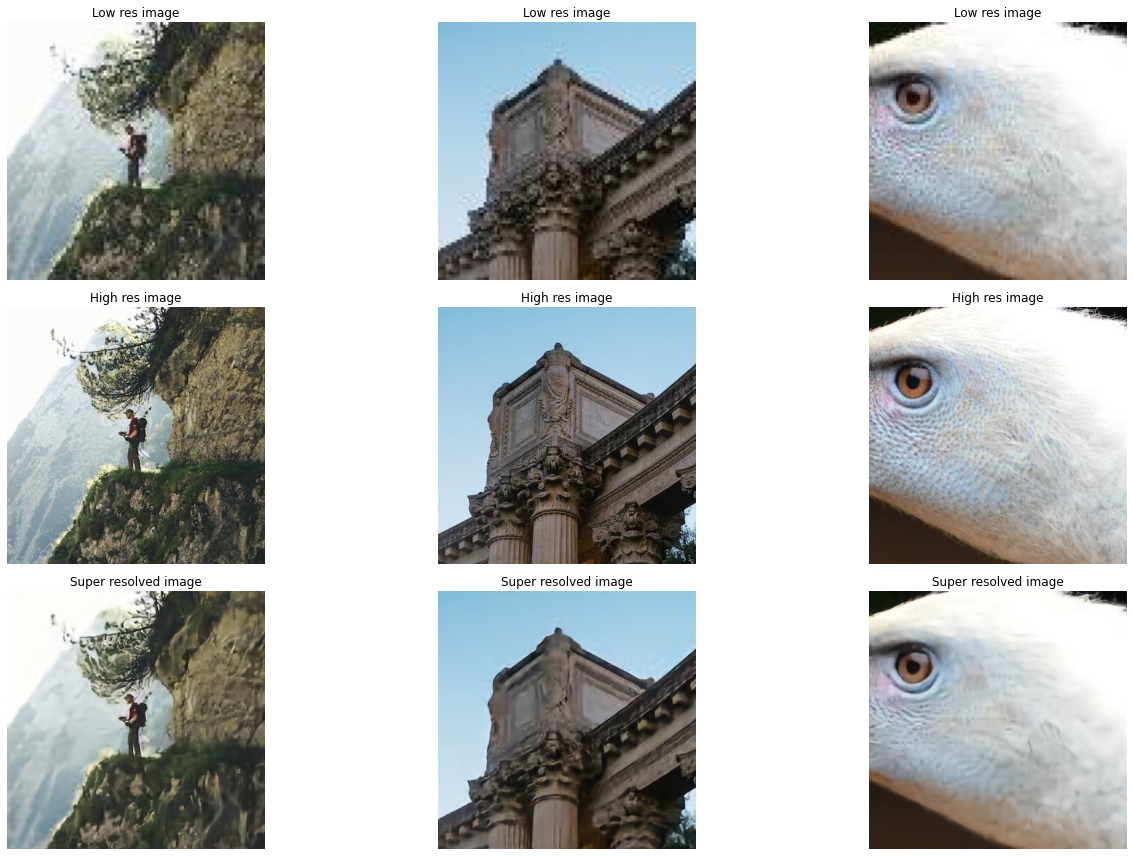

Testing:   1%|          | 2/189 [00:01<02:33,  1.22it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


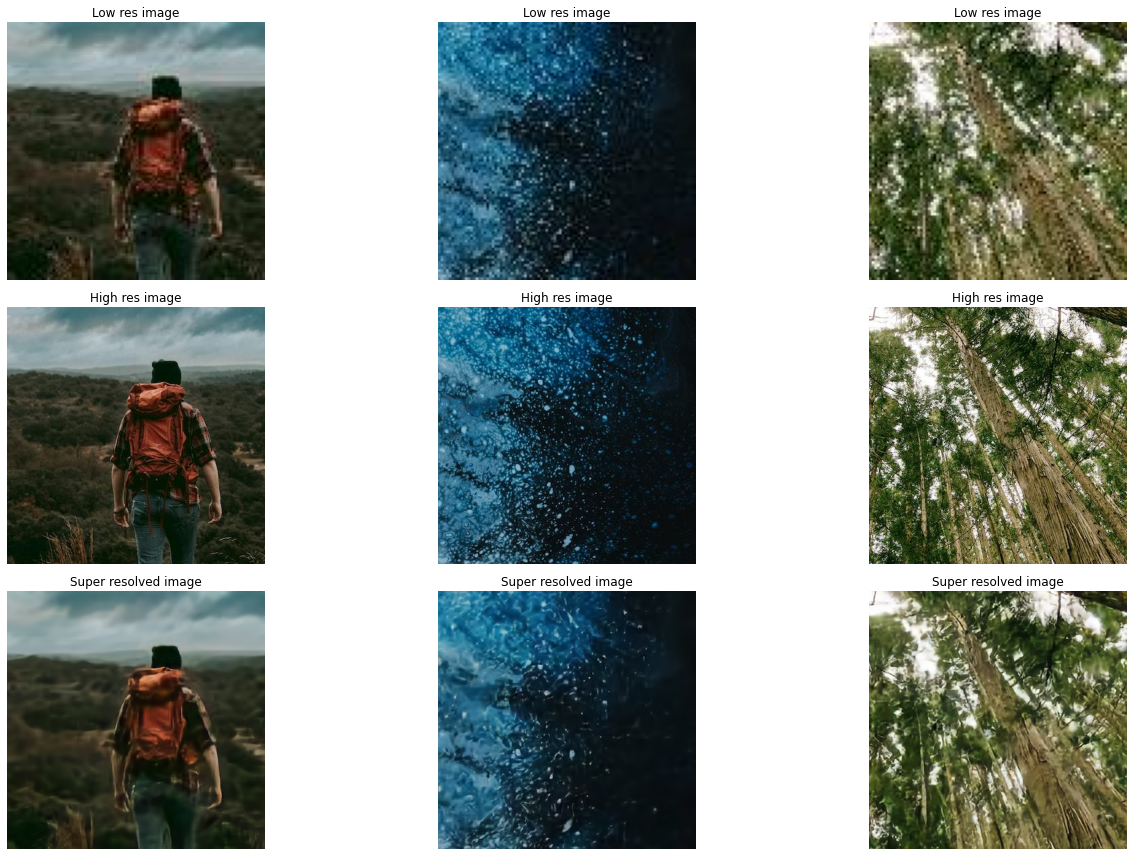

Testing:   2%|▏         | 3/189 [00:02<02:33,  1.21it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


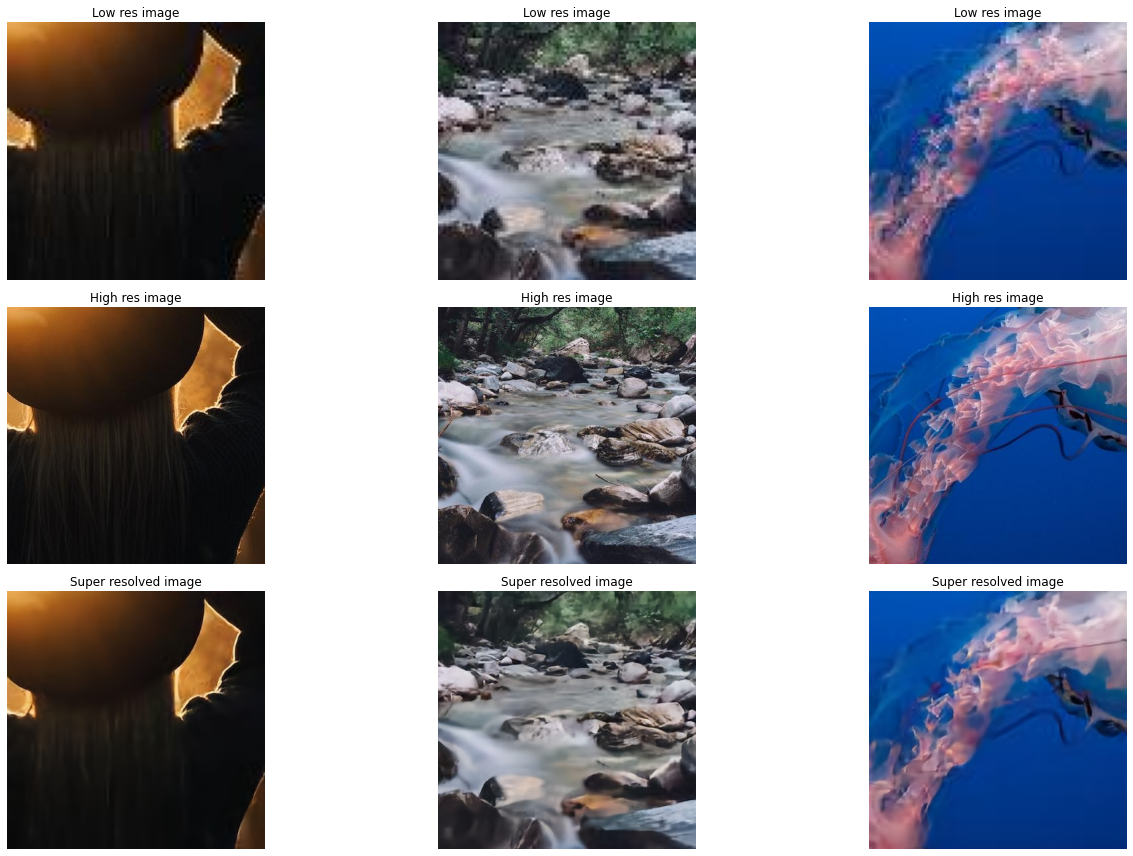

Testing:   2%|▏         | 4/189 [00:03<02:31,  1.22it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


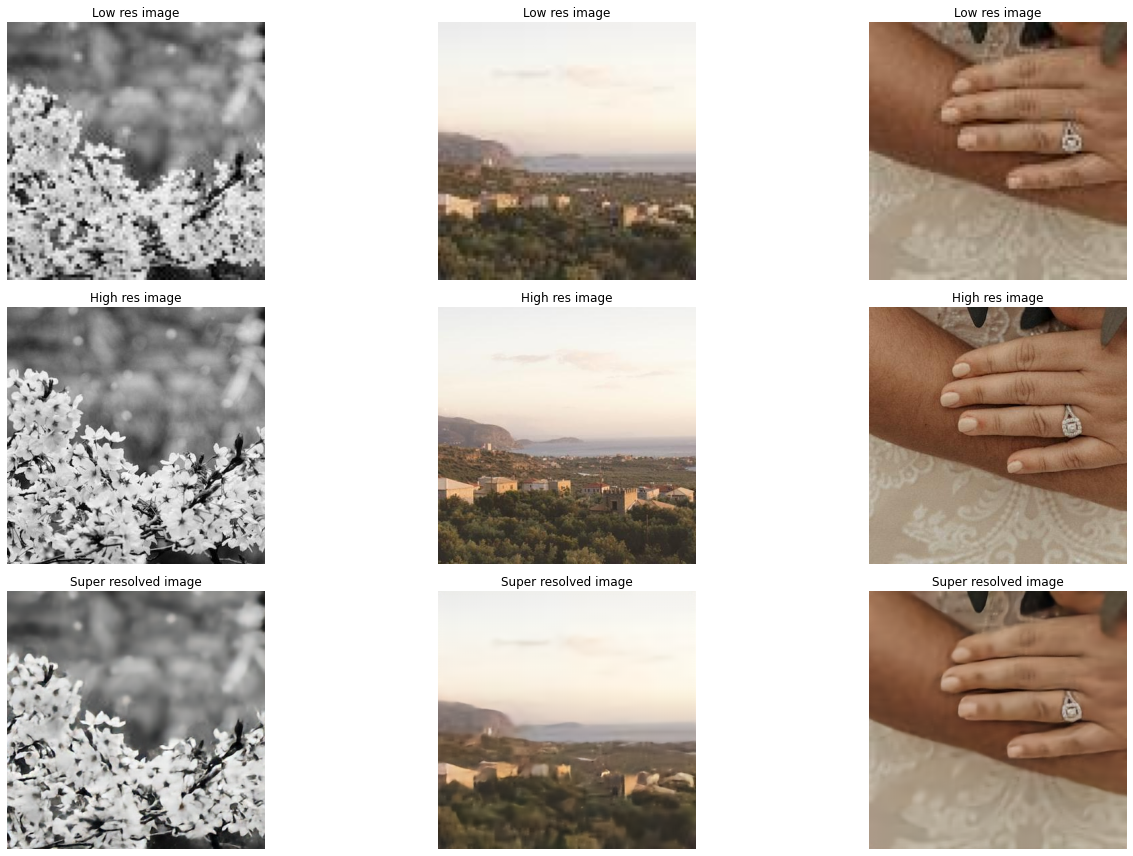

Testing: 100%|██████████| 189/189 [00:47<00:00,  3.98it/s]

PSNR value for testing dataset is : 27.053517754281298
SSIM value for testing dataset is : 0.763698299410482


In [83]:
# Test model on the single image
test_model(dbpn, test_loader)

In [81]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/ImgResProject/ImageRes/e/FSRCNN-34/metadata


### References
<ul>
    <li>https://github.com/alterzero/DBPN-Pytorch</li>
    <li>https://github.com/Lornatang/DBPN-PyTorch</li>
    <li>Haris, Muhammad, Gregory Shakhnarovich, and Norimichi Ukita. "Deep back-projection networks for super-resolution." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018.</li>
    </ul>